In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T

import matplotlib.image as mpimg

import os
import itertools

from models import CycleGAN

- Data Url  
https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/

In [7]:
class CycleDataset(Dataset):
    def __init__(self, file_dir):
        self.file_dir = file_dir
        self.file_list = os.listdir(file_dir)
        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __getitem__(self, index):
        x = mpimg.imread(self.file_dir + self.file_list[index])
        x = self.transform(x)
        return x, 0
 
    def __len__(self):
        return len(self.file_list)

In [3]:
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [4]:
for file in os.listdir('data/horse2zebra/trainB'):
    x = mpimg.imread('data/horse2zebra/trainB/' + file)
    if len(x.shape) != 3:
        print(file)

In [8]:
a_dataset = CycleDataset('data/horse2zebra/trainA/')
b_dataset = CycleDataset('data/horse2zebra/trainB/')

data_A_loader = DataLoader(a_dataset, shuffle=True)
data_B_loader = DataLoader(b_dataset, shuffle=True)

In [9]:
dtype = torch.cuda.FloatTensor

input_ngc = 3
output_ngc = 3
input_ndc = 3
output_ndc = 1
ngf = 32
ndf = 64
nb = 9 #128x128 -> 6 # 256x256 -> 9

In [10]:
G_A = CycleGAN.Generator(input_ngc, output_ngc, ngf, nb, dtype)
G_B = CycleGAN.Generator(input_ngc, output_ngc, ngf, nb, dtype)
D_A = CycleGAN.Discriminator(input_ndc, output_ndc, ndf, dtype)
D_B = CycleGAN.Discriminator(input_ndc, output_ndc, ndf, dtype)

In [11]:
for model in [G_A,G_B,D_A,D_B]:
    model.apply(reset)

In [12]:
G_optimizer = optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
D_A_optimizer = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_B_optimizer = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [13]:
lambdaA = 10
labmdaB = 10

trainer = CycleGAN.Trainer(D_A, D_A_optimizer, lambdaA, 
                  D_B, D_B_optimizer, labmdaB,
                  G_A, G_B, G_optimizer, dtype)

raw - fake - rec

Starting 1/100
Starting 2/100
Starting 3/100
Starting 4/100
Starting 5/100
{'D_A_loss': tensor(0.0608), 'D_B_loss': tensor(0.0545), 'G_A_loss': tensor(0.1132), 'G_B_loss': tensor(0.1455), 'A_cycle_loss': tensor(1.8120), 'B_cycle_loss': tensor(1.8203), 'epoch_time': 271.9393332004547}


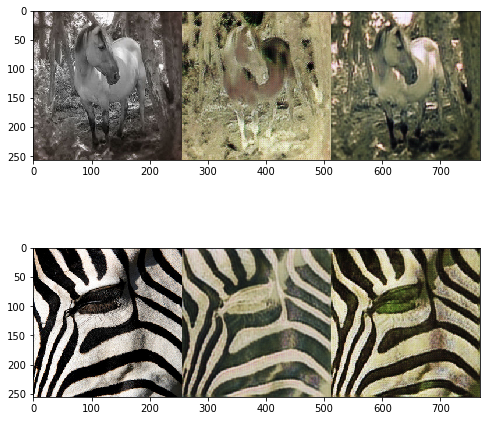

Starting 6/100
Starting 7/100
Starting 8/100
Starting 9/100
Starting 10/100
{'D_A_loss': tensor(0.0441), 'D_B_loss': tensor(0.0330), 'G_A_loss': tensor(0.0927), 'G_B_loss': tensor(0.1019), 'A_cycle_loss': tensor(1.6309), 'B_cycle_loss': tensor(1.5785), 'epoch_time': 272.252614736557}


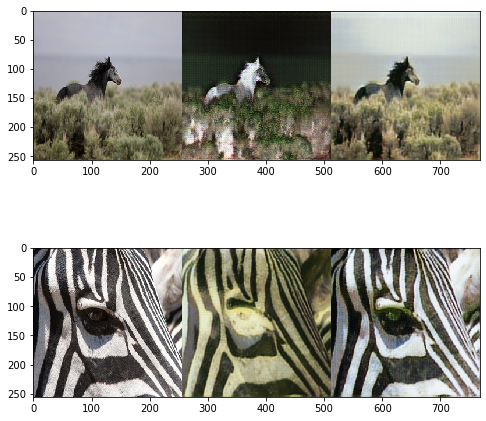

Starting 11/100
Starting 12/100
Starting 13/100
Starting 14/100
Starting 15/100
{'D_A_loss': tensor(0.0338), 'D_B_loss': tensor(0.0258), 'G_A_loss': tensor(0.0801), 'G_B_loss': tensor(0.0884), 'A_cycle_loss': tensor(1.5042), 'B_cycle_loss': tensor(1.4530), 'epoch_time': 272.06344866752625}


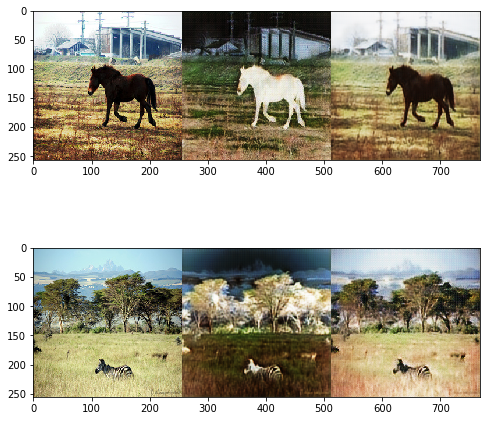

Starting 16/100
Starting 17/100
Starting 18/100
Starting 19/100
Starting 20/100
{'D_A_loss': tensor(0.0269), 'D_B_loss': tensor(0.0202), 'G_A_loss': tensor(0.0678), 'G_B_loss': tensor(0.0800), 'A_cycle_loss': tensor(1.3999), 'B_cycle_loss': tensor(1.3396), 'epoch_time': 272.14368534088135}


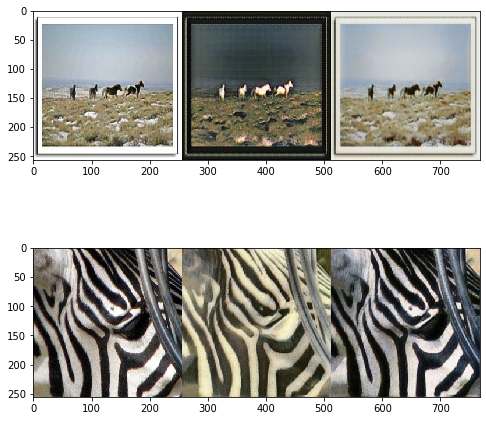

Starting 21/100
Starting 22/100
Starting 23/100
Starting 24/100
Starting 25/100
{'D_A_loss': tensor(0.0252), 'D_B_loss': tensor(0.0191), 'G_A_loss': tensor(0.0671), 'G_B_loss': tensor(0.0716), 'A_cycle_loss': tensor(1.3293), 'B_cycle_loss': tensor(1.2924), 'epoch_time': 272.5207767486572}


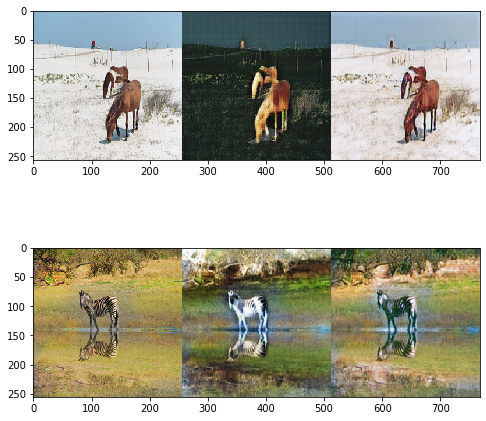

Starting 26/100
Starting 27/100
Starting 28/100
Starting 29/100
Starting 30/100
{'D_A_loss': tensor(0.0206), 'D_B_loss': tensor(0.0136), 'G_A_loss': tensor(0.0553), 'G_B_loss': tensor(0.0567), 'A_cycle_loss': tensor(1.2452), 'B_cycle_loss': tensor(1.2273), 'epoch_time': 272.33126497268677}


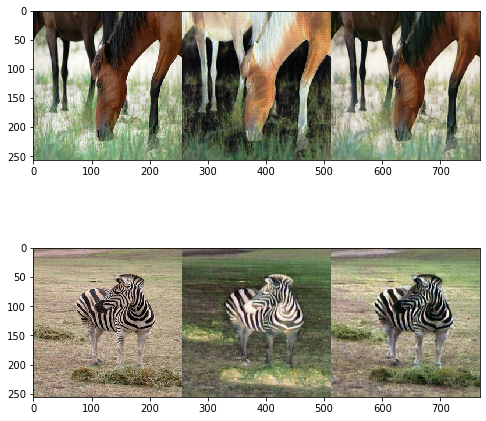

Starting 31/100
Starting 32/100
Starting 33/100
Starting 34/100
Starting 35/100
{'D_A_loss': tensor(0.0136), 'D_B_loss': tensor(0.0146), 'G_A_loss': tensor(0.0462), 'G_B_loss': tensor(0.0532), 'A_cycle_loss': tensor(1.1768), 'B_cycle_loss': tensor(1.1832), 'epoch_time': 271.70475816726685}


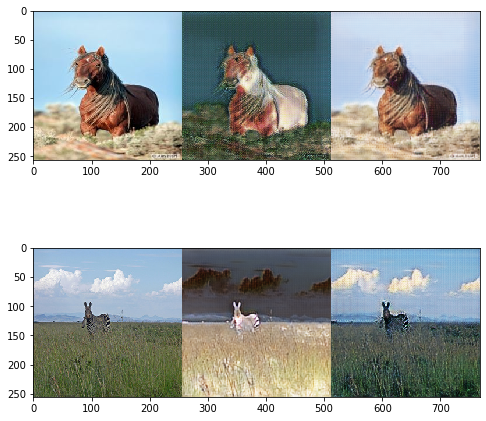

Starting 36/100


KeyboardInterrupt: 

In [14]:
trainer.train(100, data_A_loader, data_B_loader, 5)

In [15]:
torch.save(trainer.G_A, 'checkpoint/cycle/G_A_param.pkl')
torch.save(trainer.G_B, 'checkpoint/cycle/G_B_param.pkl')
torch.save(trainer.D_A, 'checkpoint/cycle/D_A_param.pkl')
torch.save(trainer.D_B, 'checkpoint/cycle/D_B_param.pkl')